##가설 2 승하차 인원 수가 많은 역일수록 무임승차 인원 이 많을 것이다(상관관계)
# 호선별 승객 이용량

In [ ]:
#향후 plt에서 쓸 한글에 글꼴 깨짐 방지를 위해 사전에 설치하였습니다
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import xml.etree.ElementTree as ET
import pandas as pd
from io import StringIO
import requests

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
#무임승차 데이터 가져오는 것
# 매핑 데이터
column_mapping = {
    'USE_MON': '사용월',
    'LINE_NUM': '호선명',
    'SUB_STA_NM': '지하철역',
    'PAY_RIDE_NUM': '유임승차인원',
    'FREE_RIDE_NUM': '무임승차인원',
    'PAY_ALIGHT_NUM': '유임하차인원',
    'FREE_ALIGHT_NUM': '무임하차인원',
    'WORK_DT': '작업일자'
}

# 데이터를 가져오는 함수
def get_data(start_index, end_index, key, month, line_num):
    url = f"http://openapi.seoul.go.kr:8088/{key}/xml/CardSubwayPayFree/{start_index}/{end_index}/{month}/"
    if line_num:  # 호선명이 주어지면 URL에 추가
        url += str(line_num)+"호선"
    response = requests.get(url)
    return response.text

# 인증키
key = "654766434f79616c31313753695a6853"
all_data = []

for mon in range(202301, 202312):  # 2023년 1월부터 11월까지 했습니다 12월은 끝이 안나서
    for line_num in range(1, 10):
        for start in range(1, 1000, 1000):  # 1000개 단위로 데이터를 가져옵니다 (예시로 1부터 시작)
            end = start + 999
            xml_data = get_data(start, end, key, mon, line_num)
            root = ET.fromstring(xml_data)

            for row in root.findall('.//row'):
                row_data = {elem.tag: elem.text for elem in row if elem.tag in column_mapping}
                all_data.append(row_data)

# DataFrame으로 변환 및 컬럼 이름 변경
df = pd.DataFrame(all_data)
df.rename(columns=column_mapping, inplace=True)
df.to_csv("대체과제파일2 원본1.csv", index=False, encoding="utf-8-sig")
print(df)

         사용월  호선명   지하철역   유임승차인원  무임승차인원   유임하차인원  무임하차인원      작업일자
0     202301  1호선    서울역  1228346  171270  1173888  161413  20230203
1     202301  1호선     시청   566559   76126   580516   73149  20230203
2     202301  1호선     종각   885821  125085   862251  117231  20230203
3     202301  1호선   종로3가   447641  271449   411958  251592  20230203
4     202301  1호선   종로5가   428412  217290   424366  209180  20230203
...      ...  ...    ...      ...     ...      ...     ...       ...
3311  202311  9호선    구반포    22368    9425    22925    9526  20231203
3312  202311  9호선    신반포    92961   29477    89996   29592  20231203
3313  202311  9호선  고속터미널   391481   70646   558234   84310  20231203
3314  202311  9호선     사평    93537   25004    89302   25091  20231203
3315  202311  9호선    신논현   862992   56641   849915   55026  20231203

[3316 rows x 8 columns]


In [ ]:
#승하차 인원 가져오기(gpt참고했습니다)

from datetime import datetime, timedelta

# 매핑 데이터
column_mapping = {
    'USE_DT': '사용일자',
    'LINE_NUM': '호선명',
    'SUB_STA_NM': '역명',
    'RIDE_PASGR_NUM': '승차총승객수',
    'ALIGHT_PASGR_NUM': '하차총승객수',
    'WORK_DT': '등록일자'
}

# 날짜 범위 생성 함수
def create_date_range(year, month):
    # 해당 월의 첫날
    start_date = datetime(year, month, 1)
    # 다음 달의 첫날에서 하루를 빼면 현재 월의 마지막 날
    end_date = datetime(year, month + 1, 1) - timedelta(days=1) if month != 12 else datetime(year, month, 31)
    return start_date.strftime('%Y%m%d'), end_date.strftime('%Y%m%d')

# 데이터를 가져오는 함수
def get_data(start_index, end_index, key, date):
    url = f"http://openapi.seoul.go.kr:8088/{key}/xml/CardSubwayStatsNew/{start_index}/{end_index}/{date}"
    response = requests.get(url)
    return response.text

# 인증키
key = "654766434f79616c31313753695a6853"
all1_data = []

# 2023년 1월부터 11월까지 데이터를 가져오는 루프
for month in range(1, 12):  # 1월부터 11월까지
    start_date, end_date = create_date_range(2023, month)
    for date in pd.date_range(start_date, end_date).strftime('%Y%m%d'):
        start_index = 1
        while True:
            end_index = start_index + 999
            xml_data = get_data(start_index, end_index, key, date)
            root = ET.fromstring(xml_data)

            # 데이터 추출
            for row in root.findall('.//row'):
                row_data = {elem.tag: elem.text for elem in row if elem.tag in column_mapping}
                all1_data.append(row_data)

            # 데이터가 더 이상 없으면 루프 종료
            if len(root.findall('.//row')) < 1000:
                break

            # 다음 페이지로 넘어감
            start_index += 1000

# DataFrame으로 변환 및 컬럼 이름 변경
df1 = pd.DataFrame(all1_data)
df1.rename(columns=column_mapping, inplace=True)
df1.to_csv("대체과제파일2 원본2.csv", index=False, encoding="utf-8-sig")
# 데이터 확인
print(df1.head())


       사용일자  호선명    역명 승차총승객수 하차총승객수      등록일자
0  20230101  1호선   서울역  31924  26931  20230104
1  20230101  1호선    시청   9282   8253  20230104
2  20230101  1호선    종각  12964  10739  20230104
3  20230101  1호선  종로3가  12847  10749  20230104
4  20230101  1호선  종로5가   9827   8974  20230104


In [ ]:
#필요 없는 열 삭제 과정
df.drop(columns=['유임승차인원', '유임하차인원', '작업일자'], inplace=True)
df1.drop(columns=['등록일자'],inplace=True)

In [ ]:
#2번째 원본 파일에서 merge를 하려고 하니 9호선 ~단계같은 data가 있어 모두 9호선으로 이름 변경
df1['호선명'] = df1['호선명'].str.replace(r'9호선2~3단계', '9호선', regex=True)
#df1 1~9호선만 남기는 작업 하기
valid_lines = [f"{i}호선" for i in range(1, 10)]
new_df = df1[df1["호선명"].isin(valid_lines)]
print(new_df)

            사용일자  호선명           역명 승차총승객수 하차총승객수
0       20230101  1호선          서울역  31924  26931
1       20230101  1호선           시청   9282   8253
2       20230101  1호선           종각  12964  10739
3       20230101  1호선         종로3가  12847  10749
4       20230101  1호선         종로5가   9827   8974
...          ...  ...          ...    ...    ...
202902  20231130  9호선         송파나루   5876   6229
202903  20231130  9호선         한성백제   3325   3191
202904  20231130  9호선  올림픽공원(한국체대)   6746   6935
202905  20231130  9호선         둔촌오륜   1285   1171
202906  20231130  9호선       중앙보훈병원  13568  11730

[104073 rows x 5 columns]


In [ ]:
new1_df=new_df.drop(columns=["역명"])
# '사용일자' 열을 datetime 객체로 변환합니다.
new1_df['사용일자'] = pd.to_datetime(new1_df['사용일자'], format='%Y%m%d')

# '사용월' 열을 추가합니다.
new1_df['사용월'] = new1_df['사용일자'].dt.strftime('%Y-%m')
print(new1_df)

             사용일자  호선명 승차총승객수 하차총승객수      사용월
0      2023-01-01  1호선  31924  26931  2023-01
1      2023-01-01  1호선   9282   8253  2023-01
2      2023-01-01  1호선  12964  10739  2023-01
3      2023-01-01  1호선  12847  10749  2023-01
4      2023-01-01  1호선   9827   8974  2023-01
...           ...  ...    ...    ...      ...
202902 2023-11-30  9호선   5876   6229  2023-11
202903 2023-11-30  9호선   3325   3191  2023-11
202904 2023-11-30  9호선   6746   6935  2023-11
202905 2023-11-30  9호선   1285   1171  2023-11
202906 2023-11-30  9호선  13568  11730  2023-11

[104073 rows x 5 columns]


In [ ]:

# '승차총승객수'와 '하차총승객수'를 숫자형으로 변환합니다.
new1_df['승차총승객수'] = pd.to_numeric(new1_df['승차총승객수'])
new1_df['하차총승객수'] = pd.to_numeric(new1_df['하차총승객수'])

# '호선명'과 '사용월'을 기준으로 그룹화하고, 승차 및 하차 승객 수를 합산합니다.
final1_df = new1_df.groupby(['호선명', '사용월']).agg({'승차총승객수':'sum', '하차총승객수':'sum'}).reset_index()

# 결과를 출력합니다.
print(final1_df)


    호선명      사용월    승차총승객수    하차총승객수
0   1호선  2023-01   6382330   6227766
1   1호선  2023-02   6587944   6437097
2   1호선  2023-03   7443904   7261929
3   1호선  2023-04   7060495   6875544
4   1호선  2023-05   7319849   7119037
..  ...      ...       ...       ...
94  9호선  2023-07  11353293  11408782
95  9호선  2023-08  11102513  11157472
96  9호선  2023-09  10893962  10942642
97  9호선  2023-10  11440921  11513738
98  9호선  2023-11  11794490  11823952

[99 rows x 4 columns]


In [ ]:
# '지하철역' 열을 제거합니다.
df = df.drop(columns=['지하철역'])

# '무임승차인원'과 '무임하차인원'을 숫자형으로 변환합니다.
df['무임승차인원'] = pd.to_numeric(df['무임승차인원'])
df['무임하차인원'] = pd.to_numeric(df['무임하차인원'])

# '호선명'과 '사용월'을 기준으로 그룹화하고, 무임 승차 및 하차 인원을 합산합니다.
final2 = df.groupby(['호선명', '사용월']).agg({'무임승차인원':'sum', '무임하차인원':'sum'}).reset_index()

# 결과를 출력합니다.
print(final2)


    호선명     사용월   무임승차인원   무임하차인원
0   1호선  202301  1709134  1681236
1   1호선  202302  1817004  1779430
2   1호선  202303  2121501  2082614
3   1호선  202304  1964202  1929746
4   1호선  202305  2026539  1991214
..  ...     ...      ...      ...
94  9호선  202307  1137713  1127461
95  9호선  202308  1122573  1114025
96  9호선  202309  1146287  1137355
97  9호선  202310  1237244  1227410
98  9호선  202311  1208637  1198447

[99 rows x 4 columns]


In [ ]:
# '사용월' 열을 문자열로 변환합니다.
final1_df['사용월'] = final1_df['사용월'].astype(str)

# '-' 문자를 제거합니다.
final1_df['사용월'] = final1_df['사용월'].str.replace('-', '')

# 두 데이터프레임 병합
group_df = pd.merge(final1_df, final2, on=['호선명', '사용월'], how='inner')


In [ ]:
print(group_df)
group_df.to_csv("기말고사 대체과제 파일2 최종 합본", index=False, encoding="utf-8-sig")

    호선명     사용월    승차총승객수    하차총승객수   무임승차인원   무임하차인원
0   1호선  202301   6382330   6227766  1709134  1681236
1   1호선  202302   6587944   6437097  1817004  1779430
2   1호선  202303   7443904   7261929  2121501  2082614
3   1호선  202304   7060495   6875544  1964202  1929746
4   1호선  202305   7319849   7119037  2026539  1991214
..  ...     ...       ...       ...      ...      ...
94  9호선  202307  11353293  11408782  1137713  1127461
95  9호선  202308  11102513  11157472  1122573  1114025
96  9호선  202309  10893962  10942642  1146287  1137355
97  9호선  202310  11440921  11513738  1237244  1227410
98  9호선  202311  11794490  11823952  1208637  1198447

[99 rows x 6 columns]


In [ ]:
#향후 plt에서 쓸 한글에 글꼴 깨짐 방지를 위해 사전에 설치하였습니다
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

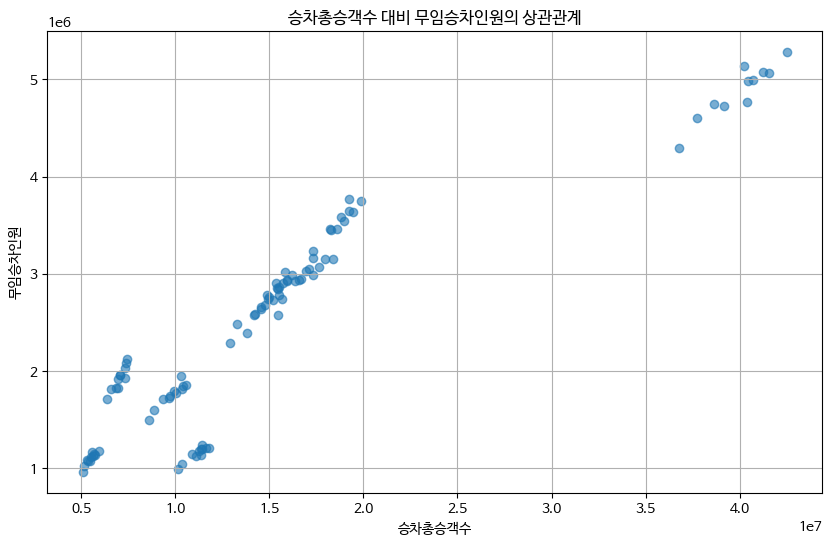

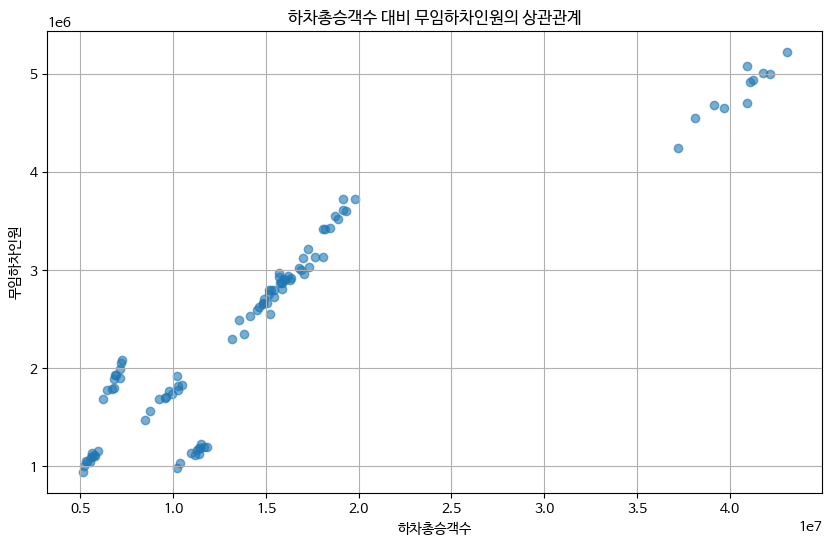

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'

# Scatter plot을 그리는 함수
def plot_scatter(df, x_column, y_column, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_column], df[y_column], alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# 승차총승객수와 무임승차인원의 상관관계
plot_scatter(group_df, '승차총승객수', '무임승차인원',
             '승차총승객수 대비 무임승차인원의 상관관계',
             '승차총승객수', '무임승차인원')

# 하차총승객수와 무임하차인원의 상관관계
plot_scatter(group_df, '하차총승객수', '무임하차인원',
             '하차총승객수 대비 무임하차인원의 상관관계',
             '하차총승객수', '무임하차인원')


<ipython-input-16-5977559e10ea>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  annual_sum_df = group_df.groupby('호선명').sum().reset_index()
<ipython-input-16-5977559e10ea>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['승차총승객수', '하차총승객수', '무임승차인원', '무임하차인원'], rotation=45)


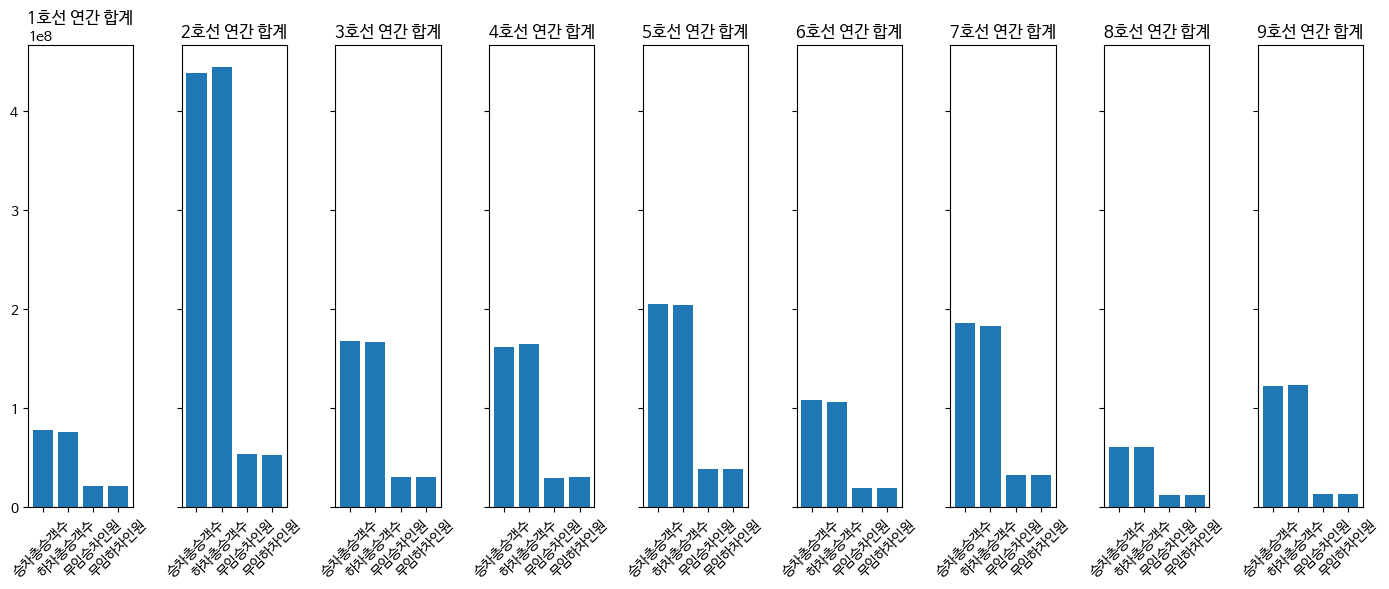

In [ ]:
import numpy as np
# 호선별로 그룹화하여 연간 합계를 구합니다.
annual_sum_df = group_df.groupby('호선명').sum().reset_index()

# 그래프를 그립니다.
# 각 호선별로 다른 서브플롯에 데이터를 그립니다.
fig, axes = plt.subplots(nrows=1, ncols=len(annual_sum_df['호선명']), figsize=(14, 6), sharey=True)

for i, (idx, row) in enumerate(annual_sum_df.iterrows()):
    ax = axes[i]
    ax.bar(['승차총승객수', '하차총승객수', '무임승차인원', '무임하차인원'],
           [row['승차총승객수'], row['하차총승객수'], row['무임승차인원'], row['무임하차인원']])
    ax.set_title(f"{row['호선명']} 연간 합계")
    ax.set_xticklabels(['승차총승객수', '하차총승객수', '무임승차인원', '무임하차인원'], rotation=45)

# 레이아웃 조정
plt.tight_layout()
plt.show()
